In [78]:
%matplotlib inline
import scipy
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
%matplotlib widget
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


import scipy
# Some useful utilities
from mcmc_utils_and_plot import scatter_matrix, build_cov_mat, lognormpdf, plot_bivariate_gauss, eval_func_on_grid



In [79]:
    gamma = 0.2
    kappa = 0.1
    r = 0.6
    delta = 0.15
    theta = np.array([gamma,kappa, r, delta]) # true parameter settings
    #theta = np.random.randn(3)
    print(theta)
    
    
    
    

[0.2  0.1  0.6  0.15]


In [80]:
def odeFunc(t,x):
    N = 1000
    S = x[0]
    I = x[1]
    R = x[2]
    y0 = delta*N - delta*S - gamma*kappa*I*S  # del S
    y1 = gamma*kappa*I*S - (r+delta)*I        # del I
    y2 = r*I - delta*R                 # del R
    return y0,y1,y2

In [81]:
def solverFunc():
    timeVec = np.linspace(0,6,61)
    S_0 = 900
    I_0 = 100
    R_0 = 0
    x_0 = np.array([S_0, I_0, R_0])
    soln = scipy.integrate.solve_ivp(odeFunc,[0,6],x_0,t_eval=timeVec,method='RK45')
    return soln

In [82]:
soln = solverFunc()
data2 = np.zeros([61,1])
stdNoise = 50 
for ii in range (0,60):
    data2[ii]=soln.y[1,ii]+stdNoise*np.random.randn()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
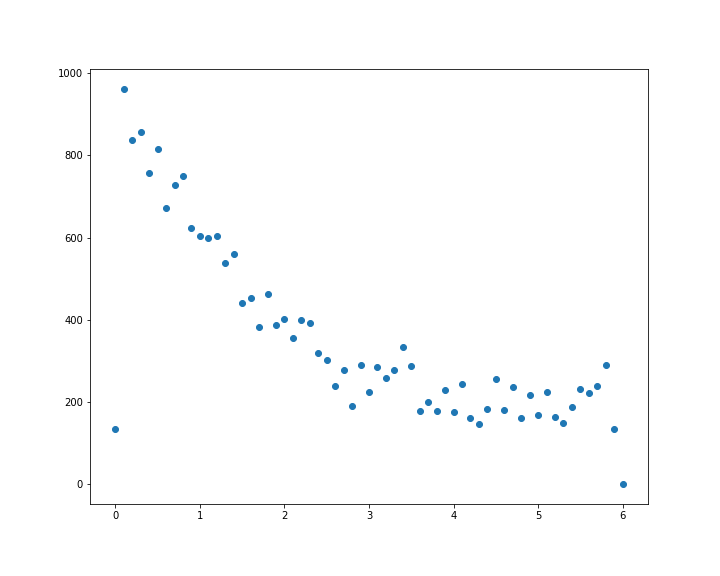

In [83]:
plt.figure(figsize=(10,8))
plt.scatter(soln.t,data1)
plt.show()

In [84]:
theta0 = np.random.randn(4)
print(theta0)

[ 0.60104897 -0.13897319 -0.47391411  1.07011319]


In [85]:
def log_likelihood(theta,data):
    timeVec = np.linspace(0,6,61)
    beta = theta[0]
    r = theta[1]
    delta = theta[2]
    S_0 = 900
    I_0 = 100
    R_0 = 0
    N = 1000
    x_0 = np.array([S_0, I_0, R_0])
    soln = scipy.integrate.solve_ivp(odeFunc,[0,6],x_0,t_eval=timeVec,method='RK45')
    
    #if np.any(soln.y<0) or np.any(soln.y>N)
    #return 0

    if np.any(np.round(np.sum(soln.y,axis=0))!=N):
        return 0 
    
    std = 50
    pre_exp_term = 1/(np.sqrt(2*np.pi)*std)
    exp_term = -0.5*np.square((data-soln.y[1,ii])/std)
#     f = pre_exp_term*np.exp(exp_term)
    f = np.log(pre_exp_term)+exp_term
    out=np.sum(f)

    return out

In [86]:
logpost = lambda params: log_likelihood(params, data2)+np.sum(np.log(scipy.stats.norm.pdf(params)))

In [87]:
log_likelihood(theta0,data1)+np.sum(np.log(scipy.stats.norm.pdf(theta0)))

-1177.797092815808

In [88]:
class DelayedRejectionAdaptiveMetropolis:
    
    def __init__(self, logpdf, cov, t0=100, freq=10, sd=None, max_samples=10000, eps=1e-7): 
        """The class constructor, parameters are documented below"""
        self.logpdf = logpdf # callable (param) -> logpdf defining the logpdf
        self.cov = cov # initial covariance
        self.cov_chol = np.linalg.cholesky(cov) # sqrt of the covariance
        self.dim = cov.shape[0] # number of parameters
        self.t0 = t0 # time to start adapting
        self.freq = freq # frequency of covariance updates (should be an integer > 0)
        if sd == None:
            self.sd = (2.4**2) / self.dim
        else:
            self.sd = sd # scale for the covariance                    
        self.max_samples = max_samples # maximum number of samples
        self.eps = eps # nugget for ensuring positive definite
        self.num_samples = 0 # number of samples generated
        self.samples = np.zeros((max_samples, self.dim)) # store the samples
        self.logpdf_vals = np.zeros((max_samples))
        
        self.sample_mean = self.samples[0,:]
        
    def sample(self, initial_sample, num_samples):
    
        assert num_samples <= self.max_samples, "Requesting more samples than space is allocated for"
        
        self.samples[0, :] = initial_sample
        self.logpdf_vals[0] = self.logpdf(initial_sample)
        
        accept = 1
        for ii in range(1, num_samples):
            
            # propose
            y = self.samples[ii-1, :] + np.dot(self.cov_chol, np.random.randn(self.dim))
            y_logpdf = self.logpdf(y)
            
            # compute accept-reject probability, using the fact that we have a symmetric proposal
            a = np.exp(y_logpdf - self.logpdf_vals[ii-1])
            a = min(a, 1)
    
            u = np.random.rand()
        
            if u < a: #accept
                self.samples[ii, :] = y
                self.logpdf_vals[ii] = y_logpdf
                accept += 1
            else:
                # propose
                chollev2 = np.linalg.cholesky(0.5*self.cov) # sqrt of the covariance
                y2 = self.samples[ii-1, :] + np.dot(chollev2, np.random.randn(self.dim))
                y_logpdf2 = self.logpdf(y2)
                
                a1y2y1 = np.exp(y_logpdf-y_logpdf2)
                a1xy1 = np.exp(y_logpdf - self.logpdf_vals[ii-1])
                
                a2 = np.exp((y_logpdf2+np.log(1-a1y2y1))-(self.logpdf_vals[ii-1]+np.log(1-a1xy1)))
                a2 = min(a2,1)
                
                u2 = np.random.rand()

                if u2 < a2: # accept
                    self.samples[ii, :] = y2
                    self.logpdf_vals[ii] = y_logpdf2
                    accept += 1
                else:
                    self.samples[ii, :] = self.samples[ii-1, :]
                    self.logpdf_vals[ii] = self.logpdf_vals[ii-1]
                    
            self.num_samples += 1
             
            
            # adapt covariance if its time
            if ii > self.t0 and ii % self.freq == 0:
#                 cov1 = (ii-1)/ii*self.cov
#                 cov2 = (1/ii)**2*np.dot(np.sum(self.samples[0:ii-1,:]),np.sum(self.samples[0:ii-1,:].T)
#                 cov3 = np.dot(np.sum(self.samples[ii,:]),np.sum(self.samples[ii,:].T)
#                 cov4 = (1/(ii+1))**2*np.dot(np.sum(self.samples[:ii,:]),np.sum(self.samples[:ii,:].T)
#                 self.cov = cov1 + self.sd/ii*(self.eps*np.eye(self.dim)+ii*cov2-(ii+1)*cov4+cov3)
#                 self.cov_chol = np.linalg.cholesky(self.cov)
                                            
                sample_mean_new = (1/(ii+1))*self.samples[ii, :]+(ii/(ii+1))*self.sample_mean
                update_term = self.eps*np.eye(self.dim) + ii*np.dot(self.sample_mean,self.sample_mean) - (
                    ii+1)*np.dot(sample_mean_new,sample_mean_new) + np.dot(self.samples[ii, :],self.samples[ii, :])
                self.cov = (ii-1)*self.cov/ii + self.sd*update_term/ii 
                self.cov_chol = np.linalg.cholesky(self.cov)
                self.sample_mean = sample_mean_new
        
                                
            if ii % 1000 == 0:
                print(f"Finished sample {ii}, acceptance ratio = {accept / self.num_samples}")
                
        return self.samples

In [89]:
def laplace_approx(initial_guess, logpost):
    """Perform the laplace approximation, 
        returning the MAP point and an approximation of the covariance
        
    Inputs
    ------
    initial_guess: (nparam, ) array of initial parameters
    logpost: function (param) -> log posterior
    
    Ouputs
    ------
    map_point: (nparam, ) MAP of the posterior
    cov_approx: (nparam, nparam), covariance matrix for Gaussian fit at MAP
    """
    def neg_post(x):
        """Negative posteror because optimizer is a minimizer"""
        return -logpost(x)
    
    # Gradient free method to obtain optimum
    res = scipy.optimize.minimize(neg_post, initial_guess, method='Nelder-Mead') 
    # Gradient method which also approximates the inverse of the hessian
    res = scipy.optimize.minimize(neg_post, res.x)

    map_point = res.x
    cov_approx = res.hess_inv
    return map_point, cov_approx

In [90]:
dim = 4
#fig = plt.figure()
guess = np.random.randn((dim)) # random guess
#guess = np.array([1,2])
map_point, cov_laplace = laplace_approx(guess, logpost)
#print(cov_laplace)
# plot_banana()
# plt.scatter(map_point[0],map_point[1])
print(map_point)
print(cov_laplace)

[-2.76064042e-07  5.97290131e-06  2.41595444e-06  6.51133337e-06]
[[ 2.04972464 -1.15549635  0.46648906 -0.84450365]
 [-1.15549635  1.17041696 -0.28366469 -0.01869283]
 [ 0.46648906 -0.28366469  1.16823544 -0.17150773]
 [-0.84450365 -0.01869283 -0.17150773  0.86696869]]


In [91]:
num_samples = 30000
# initial_sample = map_point
# cov = cov_laplace
initial_sample = np.array([1, 1,1,1])
cov = np.eye(4)
dram = DelayedRejectionAdaptiveMetropolis(logpost, cov, freq=5, t0=100, sd = None, eps = 1e-7, max_samples=num_samples)
samples = dram.sample(initial_sample,num_samples)
print(samples)

/var/folders/gh/96zwry5d5cx4lm795rfrqq8c0000gn/T/ipykernel_11942/3259420734.py:56: RuntimeWarning: invalid value encountered in log
  a2 = np.exp((y_logpdf2+np.log(1-a1y2y1))-(self.logpdf_vals[ii-1]+np.log(1-a1xy1)))


Finished sample 1000, acceptance ratio = 0.497
Finished sample 2000, acceptance ratio = 0.4845
Finished sample 3000, acceptance ratio = 0.472
Finished sample 4000, acceptance ratio = 0.46825
Finished sample 5000, acceptance ratio = 0.4668
Finished sample 6000, acceptance ratio = 0.4638333333333333
Finished sample 7000, acceptance ratio = 0.4562857142857143
Finished sample 8000, acceptance ratio = 0.453375
Finished sample 9000, acceptance ratio = 0.4524444444444444
Finished sample 10000, acceptance ratio = 0.4504
Finished sample 11000, acceptance ratio = 0.4480909090909091
Finished sample 12000, acceptance ratio = 0.44725
Finished sample 13000, acceptance ratio = 0.44576923076923075
Finished sample 14000, acceptance ratio = 0.4447857142857143
Finished sample 15000, acceptance ratio = 0.4457333333333333
Finished sample 16000, acceptance ratio = 0.444125
Finished sample 17000, acceptance ratio = 0.44335294117647056
Finished sample 18000, acceptance ratio = 0.4433888888888889
Finished samp

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
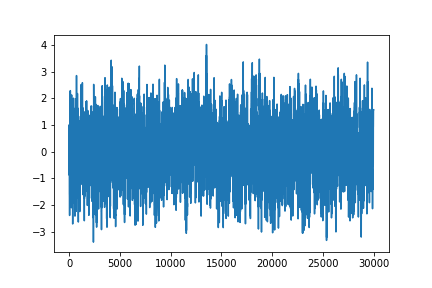

[-0.66125441 -0.77078356 -0.77078356 -0.77078356 -0.77078356 -0.77078356
 -0.77078356 -0.77078356 -0.76201738 -0.52561916 -0.52561916 -0.52561916
 -1.90252342 -1.90252342 -1.90252342 -1.90252342 -1.90252342 -1.90252342
 -1.03470147 -0.33602132 -0.29282689 -0.29282689 -0.29282689 -0.29282689
 -0.29282689 -0.29282689 -0.29282689 -0.29282689 -0.29282689 -0.29282689
 -0.29282689 -0.66088507  0.08101977 -1.01050111 -1.01050111 -1.97146664
 -1.65333899 -0.28138558  0.32715318 -0.26366538 -1.16248932 -1.16248932
 -0.33997633 -1.136498   -1.136498   -1.136498   -1.71533145 -1.71533145
 -2.055859   -2.24075377]


In [98]:
# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# axs[0].plot(lags, autolag[:, 0],'-o')
plt.figure()
plt.plot(samples[:,1])
plt.show()
print(samples[1000:1050,1])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
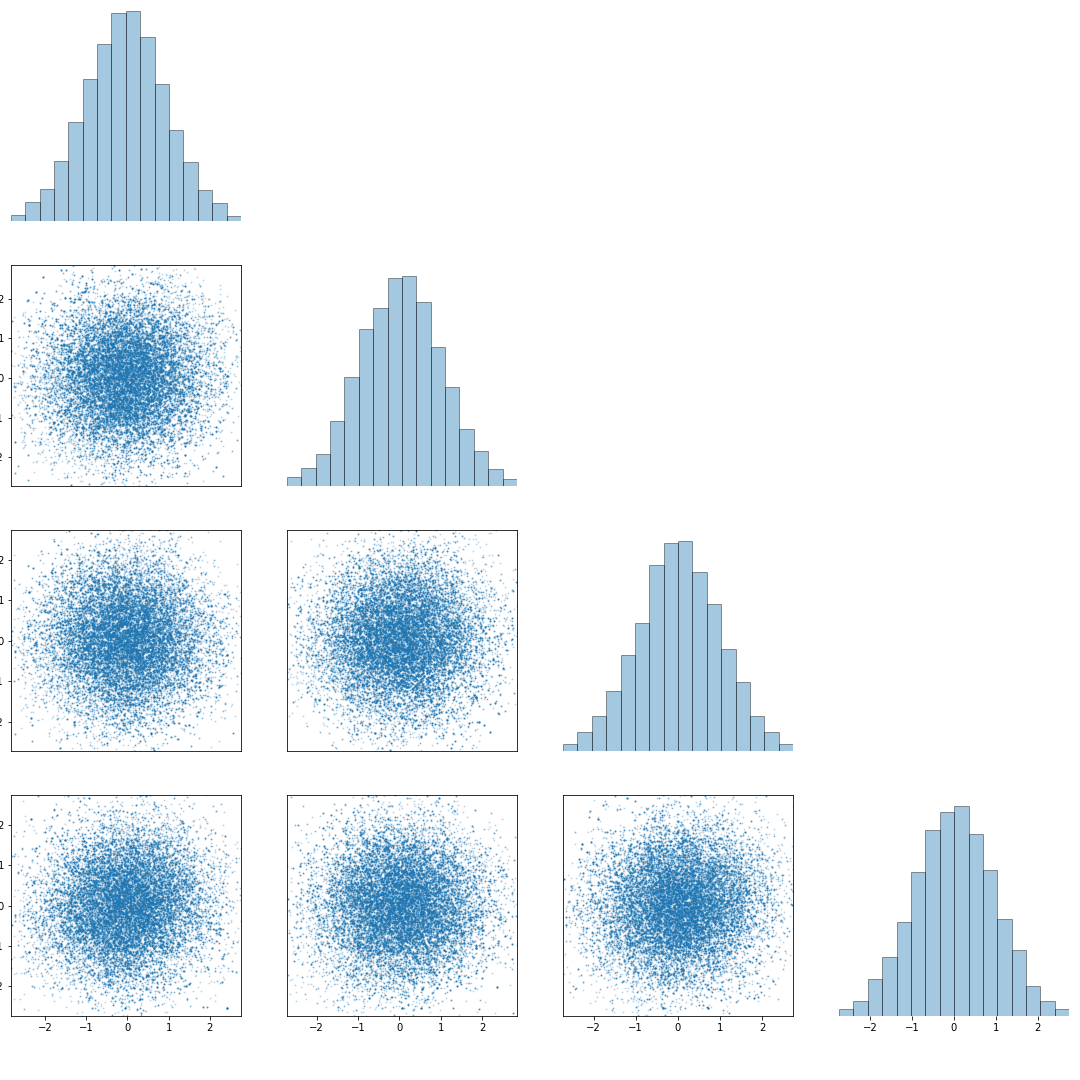

In [92]:
fig, axs, gs = scatter_matrix([samples], hist_plot=False, gamma=0.2)
fig.set_size_inches(15,15)
plt.subplots_adjust(left=0.01, right=0.99, wspace=0.2, hspace=0.2)